In [4]:
#CREAR UN INDEX PARA ALMACENAR LOS DATOS
from elasticsearch import Elasticsearch
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import datetime
es = Elasticsearch()


def timestamp2date(x):
    y = datetime.datetime.fromtimestamp(x/1000).strftime('%H:%M:%S')
    return y

if not(es.indices.exists(index="tp5-championstweets")):
    res = es.indices.create(index="tp5-championstweets")  
    pprint(res)

<b>1) ¿Cuántos tweets tienen la palabra "liverpool"? ¿Cómo se distribuye los tweets en el tiempo (ver en un histograma)</b>

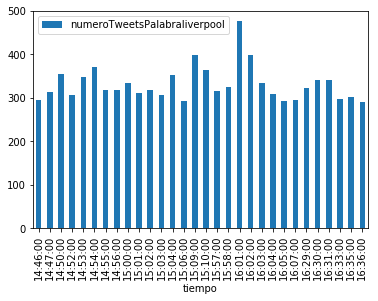

In [10]:
lv = es.search(index="tp5-championstweets", body={"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}},"query": {"match": {'text':'liverpool'}}})
lvm= pd.DataFrame(lv['aggregations']['tweets_over_time']['buckets'])
lvm=lvm.rename(columns={'key': 'tiempo', 'doc_count': 'numeroTweetsPalabraliverpool'})
lvm['tiempo']=lvm['tiempo'].apply(timestamp2date)
lvm=lvm.drop(lvm[lvm.numeroTweetsPalabraliverpool<290].index) #filtré, muchos datos :c
lvm.plot(kind='bar',x='tiempo')

<b>2) ¿De dónde vienen los tweets? (utilizar el campo 'location') </b>

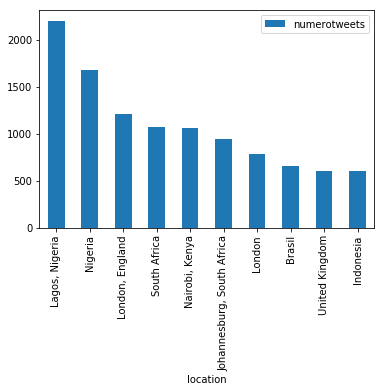

In [16]:
rescountry = es.search(index="tp5-championstweets",body={
  "aggs": {
    "grb": {
      "terms": {
        "field": "location.keyword"
      }
    }
  }
})
countryframe=pd.DataFrame(rescountry['aggregations']['grb']['buckets'])
countryframe=countryframe.rename(columns={'key': 'location', 'doc_count': 'numerotweets'})
countryframe.plot(kind="bar",x="location")



<b>3) ¿Cuántos tweets tienen las palabras "liverpool" y "goal"? (ver en un histograma) </b>

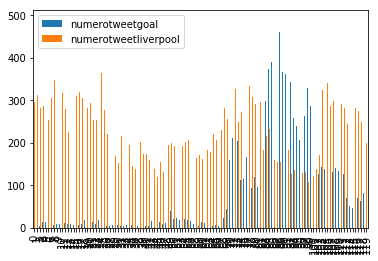

In [107]:
resgoal = es.search(index="tp5-championstweets",body={"query": {"term": {'text':'goal'}},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
resliverpool=es.search(index="tp5-championstweets",body={"query": {"term":{'text':'liverpool'}},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
goal=pd.DataFrame(resgoal['aggregations']['tweets_over_time']['buckets'])
lv=pd.DataFrame(resliverpool['aggregations']['tweets_over_time']['buckets'])
goal=goal.rename(columns={'key': 'timestamp', 'doc_count': 'numerotweetgoal'})
lv=lv.rename(columns={'key': 'timestamp', 'doc_count': 'numerotweetliverpool'})
goal['timestamp']=goal['timestamp'].apply(timestamp2date)
lv['timestamp']=lv['timestamp'].apply(timestamp2date)
goalv=pd.merge(goal,lv,on='timestamp')
goalv.plot(kind='bar')


<b>4) Graficar un Pie Chart comparando el número de tweets con: a) la palabra 'liverpool', b) la palabra 'madrid', c) la palabra 'madrid' y 'liverpool' d) ninguna de las palabras </b>

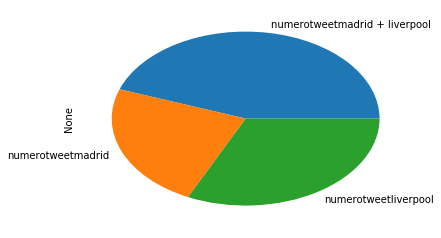

In [127]:
resmad = es.search(index="tp5-championstweets",body={"query": {"term": {'text':'madrid'}},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
resmal = es.search(index="tp5-championstweets",body={"query": {"match": {'text':'(madrid)+( )* (liverpool)+'}},"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
madrid=pd.DataFrame(resmad['aggregations']['tweets_over_time']['buckets'])
mal=pd.DataFrame(resmal['aggregations']['tweets_over_time']['buckets'])
madrid=madrid.rename(columns={'key': 'timestamp', 'doc_count': 'numerotweetmadrid'})
mal=mal.rename(columns={'key': 'timestamp', 'doc_count': 'numerotweetmadrid + liverpool'})
madrid['timestamp']=madrid['timestamp'].apply(timestamp2date)
mal['timestamp']=mal['timestamp'].apply(timestamp2date)
dff=pd.merge(mal,madrid,on='timestamp')
dff=pd.merge(dff,lv,on='timestamp')
dff[['numerotweetmadrid + liverpool','numerotweetmadrid','numerotweetliverpool']].sum().plot(kind='pie')

<b>5) ¿Cuáles son los emoticons más frecuentes? A partir de las visualizaciones disponibles en las librerias MatplotLib y/o Seaborn (seaborn.pydata.org), proponer una visualización para observar las emociones expresadas durante el partido </b>

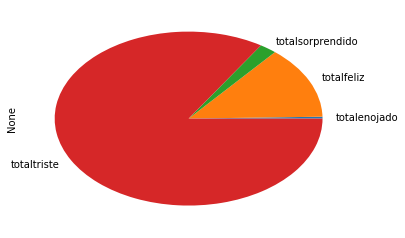

In [142]:
feliz = es.search(index="tp5-championstweets",body={"query": {"match": {'text':'feliz'}}})
triste= es.search(index="tp5-championstweets",body={"query": {"match": {'text':'triste'}}})
enojado=es.search(index="tp5-championstweets",body={"query": {"match": {'text':'enojado'}}})
sorprendido=es.search(index="tp5-championstweets",body={"query": {"match": {'text':'sorprendido'}}})
emociones={'totalfeliz':[feliz['hits']['total']],'totaltriste':[triste['hits']['total']],'totalenojado':[enojado['hits']['total']]
          ,'totalsorprendido':[sorprendido['hits']['total']]}
emociondata=pd.DataFrame(data=emociones)
emociondata.sum().plot(kind='pie')
#la visualizacion es un ejemplo de lo que haria si tuviera acceso o si conociera como trabajar con los emoticonos

In [136]:
#CONSULTA BÁSICA A ELASTICSEARCH PARA PROBAR
res = es.search(index="tp5-championstweets", body={"query": {"term":{"text":"goal"}}})
print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    print("TWEET:%(text)s %(username)s: %(date)s" % hit["_source"])

Got 10636 Hits:
TWEET:Goal goal goal goal goal goal!!!!!!!!!!!!!!!!!!!!!! #RealMadrid #RMALIV #UCLfinal Preveza Epirus: Sat May 26 20:13:28 +0000 2018
TWEET:Super goal goal goal goal goal https://t.co/FVh1CVOEGA Abouuuuuuuuuuuuu Impala: Sat May 26 20:12:56 +0000 2018
TWEET:GOAL GOAL GOAL GOAL GOOOAAAAL MANEEEEE #UCLFinal NooR: Sat May 26 20:01:07 +0000 2018
TWEET:Goal Goal Goal!!!!! 
@KraksTV 
#UCLFinal https://t.co/H8cDjge8hi Unilag Ajebutter: Sat May 26 19:56:06 +0000 2018
TWEET:Goal! Goal! Goal! Typical Liverpool goalkeepers #UCLfinal #HalaMadrid Tlholo conquer: Sat May 26 19:56:24 +0000 2018
TWEET:#UCLfinal

Never felt this alive. Goal goal goal Gagan: Sat May 26 20:01:30 +0000 2018
TWEET:Yeyyyy😃😃 goal ,goal😃😃😃
#UCLfinal A girl with a brain without mind.: Sat May 26 20:25:25 +0000 2018
TWEET:What a goal 😰😰😰 satu goal konyol dan satu lagi goal berkelas #LIVRMA #UCLfinal Nova Nurpadilah: Sat May 26 20:11:58 +0000 2018
TWEET:Benzema goal was like Beginners Goal in Fifa,
Mane goal was 